# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
# from sklearn.dummy import DummyRegressor

SEED = 41

MS = 60000
SECONDS = 60

## Подготовка данных

In [3]:
try:
    df = pd.read_csv('../datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
# посмотрим на случайные 10 объектов датасета
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
341706,2016-03-24 10:41:07,12499,sedan,2007,auto,170,c_klasse,125000,7,gasoline,mercedes_benz,no,2016-03-24 00:00:00,0,22523,2016-03-30 09:46:52
158199,2016-03-28 14:36:22,1500,sedan,2000,manual,136,3er,5000,0,gasoline,bmw,no,2016-03-28 00:00:00,0,46446,2016-03-28 14:36:22
20059,2016-03-28 20:50:42,3300,sedan,2003,manual,101,a3,150000,9,gasoline,audi,NaN,2016-03-28 00:00:00,0,84028,2016-04-07 03:44:34
311339,2016-04-02 13:48:11,8250,wagon,2007,manual,140,a4,150000,4,gasoline,audi,no,2016-04-02 00:00:00,0,89584,2016-04-06 12:16:19
4640,2016-03-25 11:56:31,11250,suv,1999,auto,120,g_klasse,150000,7,gasoline,mercedes_benz,no,2016-03-25 00:00:00,0,66987,2016-03-25 11:56:31
85441,2016-03-13 00:58:51,1300,convertible,1994,manual,115,mx_reihe,150000,1,petrol,mazda,NaN,2016-03-12 00:00:00,0,48599,2016-03-13 06:47:01
71929,2016-04-03 13:55:22,1190,NaN,2016,manual,0,polo,150000,5,petrol,volkswagen,NaN,2016-04-03 00:00:00,0,16909,2016-04-03 13:55:22
89162,2016-03-20 16:50:50,1000,small,1995,NaN,0,polo,150000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,89155,2016-03-28 17:17:51
33955,2016-03-14 16:47:55,6950,small,2010,NaN,0,corsa,30000,9,petrol,opel,no,2016-03-14 00:00:00,0,49134,2016-04-05 21:16:23
154413,2016-03-30 18:53:54,2600,small,2005,manual,69,fiesta,150000,5,petrol,ford,no,2016-03-30 00:00:00,0,74078,2016-04-07 10:17:05


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
# Посмотрим на процент пропущенных данных по колонкам
pd.DataFrame(df.isna().mean() * 100).sort_values(0, ascending=False)[:10]

,0
NotRepaired,20.079070
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


In [7]:
# Функция для разбиения колонки с датой на несколько колонок
def custom_date(data:pd.DataFrame, column:str, format_template:str, drop=True):
    '''function to aggregate date columns 
    '''
    dt_agg = pd.to_datetime(data[column], format=format_template)
    data[column + '_year'] = dt_agg.dt.year
    data[column + '_month'] = dt_agg.dt.month
    data[column + '_day'] = dt_agg.dt.day
    if drop:
        data = data.drop(column, axis=1)
    return data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
# Приведем названия колонок к змеиному регистру
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()

# Удаляем автомобили с датой регистрации до 1980 года и после 2016
df = df.drop(df.query("registration_year < 1980 or registration_year > @pd.to_datetime(@df['date_crawled']).dt.year").index) 

# gasoline и petrol - одно и то же, исправим эту ошибку. Пропуски заполним значением not_defined
df['fuel_type'].replace('gasoline', 'petrol', inplace=True)
df['fuel_type'].fillna('not_defined', inplace=True)

# Предполагаю, что модель авто имеет важное значение для качества предсказаний, эти данные удалим.
df.dropna(subset=['model'], inplace=True)

# Будем считать, что незаполненные значения означают, что машина не была в ремонте. 
df['not_repaired'] = df['not_repaired'].fillna('no')


df['vehicle_type'].fillna('not_defined', inplace=True)
df['gearbox'].fillna('not_defined', inplace=True)

# Удалим значения равные нулю.
df = df.drop(df[(df['price'] == 0) | 
  (df['power'] == 0)].index)

# Удалим значения, где мощность более 500 л.с.
df = df.drop(df.query("power > 500").index)

# Добавим признак - возраст автомобиля
df['age'] = pd.to_datetime(df['date_created']).dt.year - pd.to_datetime(df['registration_year'], format="%Y").dt.year

# Чтобы модель могла работать с датами, нужно сделать отдельные колонки для года, месяца и дня
df = custom_date(df, 'date_created', "%Y-%m-%d")
df = custom_date(df, 'last_seen', "%Y-%m-%d")

#  Удалим ненужные колонки 
df = df.drop(['number_of_pictures', 
              'date_crawled', 
              'postal_code', 
              'registration_month'], axis=1)

df['model'] = df['model'].dropna()


/var/folders/j2/rv6w5j790dq31zz952rgp0j00000gn/T/ipykernel_1834/2375550118.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()


In [10]:
features = df.drop('price', axis=1)
target = df.price

X_train, X_valid, y_train, y_valid = train_test_split(features, 
                                                      target, 
                                                      test_size=.3, 
                                                      random_state=SEED
                                                     )

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                   y_valid,
                                                   test_size=.5,
                                                   random_state=SEED
                                                   )

## Обучение моделей

In [11]:
def get_scores(report_df, model, X_test, y_test, name, manual_value=False, 
               fit_time=False, predict_time=False):
    
    report = pd.DataFrame(columns={'RMSE'}, data=[0])
    report.index = [name]
    if manual_value: 
        report['RMSE'] = manual_value
    else:
        predictions = model.predict(X_test)
    
        report['RMSE'] = abs(mean_squared_error(y_test, predictions, squared=False))
    if fit_time:
        report['fit_time'] = fit_time
    if predict_time:
        report['predict_time'] = predict_time
    report_df = report_df.append(report)
    return report_df

### Random Forest

In [12]:
# Списки с категориальными и численными данными

cat_cols = X_train.select_dtypes(['category', 'object']).columns
num_cols = X_train.select_dtypes(exclude='O').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="median"), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', 
                              unknown_value=-1), cat_cols)
    ]
)


In [13]:
%%time
rf_model = Pipeline(
    steps=[('preproc', preprocessor),
           ('model', RandomForestRegressor(random_state=SEED))]
)


params = {
    'model__max_depth':[6,10],
    'model__n_estimators':[50]
}


rf_search = RandomizedSearchCV(rf_model,
                              params,
                               scoring='neg_root_mean_squared_error',
                               cv=3,
                               verbose=10,
                               n_jobs=-1
)
rf_search.fit(X_train, y_train)

display(abs(rf_search.best_score_))



Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


1828.883507862721

CPU times: user 13.5 s, sys: 235 ms, total: 13.8 s
Wall time: 25.8 s


In [14]:
%%time
rf_search.best_estimator_.predict(X_test)

CPU times: user 176 ms, sys: 4.76 ms, total: 181 ms
Wall time: 180 ms


array([ 989.96700614, 4209.4693439 ,  823.08226791, ..., 8847.26420151,
       2361.06815738, 1229.87522414])

In [15]:

# Добавим результат в отчет.
report_df = pd.DataFrame()
report_df = get_scores(report_df, 
                       rf_search.best_estimator_, 
                       X_valid,
                       y_valid, 
                       'random_forest',
                       fit_time=1.37 * SECONDS,
                      predict_time=414 / MS)
report_df

,RMSE,fit_time,predict_time
random_forest,1814.80811,82.2,0.0069


### Catboost

In [16]:
%%time
cb_model = CatBoostRegressor(eval_metric='RMSE', 
                             random_seed=SEED,
                             cat_features=list(cat_cols),
                             early_stopping_rounds=20
                            )
grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]
       }

cb_results = cb_model.grid_search(grid,
                                 X_train,
                                 y_train,
                                 plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6531.6131187	test: 6551.4642011	best: 6551.4642011 (0)	total: 123ms	remaining: 2m 2s
1:	learn: 6366.6656940	test: 6387.0497932	best: 6387.0497932 (1)	total: 173ms	remaining: 1m 26s
2:	learn: 6207.0337195	test: 6227.8969129	best: 6227.8969129 (2)	total: 213ms	remaining: 1m 10s
3:	learn: 6053.9910958	test: 6075.0443384	best: 6075.0443384 (3)	total: 262ms	remaining: 1m 5s
4:	learn: 5906.0670759	test: 5927.2171424	best: 5927.2171424 (4)	total: 303ms	remaining: 1m
5:	learn: 5761.7627233	test: 5783.0815842	best: 5783.0815842 (5)	total: 354ms	remaining: 58.7s
6:	learn: 5622.5142186	test: 5644.3129464	best: 5644.3129464 (6)	total: 397ms	remaining: 56.3s
7:	learn: 5487.9589455	test: 5509.9143106	best: 5509.9143106 (7)	total: 434ms	remaining: 53.8s
8:	learn: 5357.4326592	test: 5379.8441052	best: 5379.8441052 (8)	total: 470ms	remaining: 51.8s
9:	learn: 5231.4160362	test: 5254.2577986	best: 5254.2577986 (9)	total: 509ms	remaining: 50.4s
10:	learn: 5109.4114047	test: 5132.3118280	best: 51

87:	learn: 2007.0009792	test: 2030.5775363	best: 2030.5775363 (87)	total: 3.44s	remaining: 35.7s
88:	learn: 2000.1484460	test: 2023.6682899	best: 2023.6682899 (88)	total: 3.48s	remaining: 35.6s
89:	learn: 1993.9216557	test: 2017.2429313	best: 2017.2429313 (89)	total: 3.5s	remaining: 35.4s
90:	learn: 1987.8043087	test: 2011.0900612	best: 2011.0900612 (90)	total: 3.54s	remaining: 35.4s
91:	learn: 1981.5973561	test: 2004.5975045	best: 2004.5975045 (91)	total: 3.57s	remaining: 35.2s
92:	learn: 1975.5348859	test: 1998.5818415	best: 1998.5818415 (92)	total: 3.61s	remaining: 35.3s
93:	learn: 1969.8383411	test: 1992.6528906	best: 1992.6528906 (93)	total: 3.65s	remaining: 35.2s
94:	learn: 1964.2266420	test: 1986.9483572	best: 1986.9483572 (94)	total: 3.69s	remaining: 35.1s
95:	learn: 1958.9239674	test: 1981.7193805	best: 1981.7193805 (95)	total: 3.72s	remaining: 35s
96:	learn: 1953.8422890	test: 1976.5714014	best: 1976.5714014 (96)	total: 3.76s	remaining: 35s
97:	learn: 1948.6803257	test: 1971.

173:	learn: 1782.2779535	test: 1801.9250480	best: 1801.9250480 (173)	total: 6.54s	remaining: 31s
174:	learn: 1781.0904357	test: 1800.8204506	best: 1800.8204506 (174)	total: 6.58s	remaining: 31s
175:	learn: 1780.4027124	test: 1800.1583112	best: 1800.1583112 (175)	total: 6.62s	remaining: 31s
176:	learn: 1779.5974436	test: 1799.2453106	best: 1799.2453106 (176)	total: 6.66s	remaining: 30.9s
177:	learn: 1778.7262464	test: 1798.2731740	best: 1798.2731740 (177)	total: 6.69s	remaining: 30.9s
178:	learn: 1777.5055217	test: 1797.0649505	best: 1797.0649505 (178)	total: 6.73s	remaining: 30.9s
179:	learn: 1776.4517518	test: 1796.0028781	best: 1796.0028781 (179)	total: 6.76s	remaining: 30.8s
180:	learn: 1775.6264504	test: 1795.0366714	best: 1795.0366714 (180)	total: 6.8s	remaining: 30.8s
181:	learn: 1774.4332097	test: 1793.8489978	best: 1793.8489978 (181)	total: 6.83s	remaining: 30.7s
182:	learn: 1773.3866864	test: 1792.8619521	best: 1792.8619521 (182)	total: 6.86s	remaining: 30.6s
183:	learn: 1772.

257:	learn: 1720.7810767	test: 1739.1915800	best: 1739.1915800 (257)	total: 9.63s	remaining: 27.7s
258:	learn: 1720.3044490	test: 1738.7179608	best: 1738.7179608 (258)	total: 9.66s	remaining: 27.6s
259:	learn: 1719.8745293	test: 1738.2787688	best: 1738.2787688 (259)	total: 9.7s	remaining: 27.6s
260:	learn: 1719.2217892	test: 1737.5440637	best: 1737.5440637 (260)	total: 9.73s	remaining: 27.5s
261:	learn: 1718.5366388	test: 1736.9248078	best: 1736.9248078 (261)	total: 9.76s	remaining: 27.5s
262:	learn: 1718.0714610	test: 1736.4530136	best: 1736.4530136 (262)	total: 9.79s	remaining: 27.4s
263:	learn: 1717.6321299	test: 1736.0155254	best: 1736.0155254 (263)	total: 9.82s	remaining: 27.4s
264:	learn: 1717.1481450	test: 1735.6472000	best: 1735.6472000 (264)	total: 9.86s	remaining: 27.4s
265:	learn: 1716.6468966	test: 1735.2040828	best: 1735.2040828 (265)	total: 9.9s	remaining: 27.3s
266:	learn: 1715.8049796	test: 1734.4576481	best: 1734.4576481 (266)	total: 9.92s	remaining: 27.2s
267:	learn: 

346:	learn: 1677.2566732	test: 1697.3066668	best: 1697.3066668 (346)	total: 12.9s	remaining: 24.3s
347:	learn: 1676.8181362	test: 1696.9749822	best: 1696.9749822 (347)	total: 13s	remaining: 24.3s
348:	learn: 1676.5029680	test: 1696.7131595	best: 1696.7131595 (348)	total: 13s	remaining: 24.2s
349:	learn: 1676.1041499	test: 1696.4072806	best: 1696.4072806 (349)	total: 13s	remaining: 24.2s
350:	learn: 1675.7415802	test: 1696.0183311	best: 1696.0183311 (350)	total: 13.1s	remaining: 24.2s
351:	learn: 1675.2838890	test: 1695.6031022	best: 1695.6031022 (351)	total: 13.1s	remaining: 24.1s
352:	learn: 1674.8520291	test: 1695.1617842	best: 1695.1617842 (352)	total: 13.1s	remaining: 24.1s
353:	learn: 1674.5840167	test: 1694.9532103	best: 1694.9532103 (353)	total: 13.2s	remaining: 24s
354:	learn: 1674.2234751	test: 1694.6671007	best: 1694.6671007 (354)	total: 13.2s	remaining: 24s
355:	learn: 1673.8698765	test: 1694.2838124	best: 1694.2838124 (355)	total: 13.3s	remaining: 24s
356:	learn: 1673.39493

433:	learn: 1646.3979689	test: 1667.8697623	best: 1667.8697623 (433)	total: 16s	remaining: 20.9s
434:	learn: 1646.0259880	test: 1667.5300282	best: 1667.5300282 (434)	total: 16.1s	remaining: 20.9s
435:	learn: 1645.7699543	test: 1667.2907651	best: 1667.2907651 (435)	total: 16.1s	remaining: 20.8s
436:	learn: 1645.3974058	test: 1666.9060663	best: 1666.9060663 (436)	total: 16.1s	remaining: 20.8s
437:	learn: 1645.1182653	test: 1666.6662415	best: 1666.6662415 (437)	total: 16.2s	remaining: 20.8s
438:	learn: 1644.8981704	test: 1666.5259466	best: 1666.5259466 (438)	total: 16.2s	remaining: 20.7s
439:	learn: 1644.4445742	test: 1666.2335132	best: 1666.2335132 (439)	total: 16.3s	remaining: 20.7s
440:	learn: 1644.0995307	test: 1665.9444155	best: 1665.9444155 (440)	total: 16.3s	remaining: 20.6s
441:	learn: 1643.7131140	test: 1665.6533452	best: 1665.6533452 (441)	total: 16.3s	remaining: 20.6s
442:	learn: 1643.4332226	test: 1665.4252670	best: 1665.4252670 (442)	total: 16.4s	remaining: 20.6s
443:	learn: 

517:	learn: 1623.1509913	test: 1647.2785812	best: 1647.2785812 (517)	total: 19.1s	remaining: 17.8s
518:	learn: 1623.0309137	test: 1647.1939674	best: 1647.1939674 (518)	total: 19.2s	remaining: 17.8s
519:	learn: 1622.7630843	test: 1646.9391388	best: 1646.9391388 (519)	total: 19.2s	remaining: 17.7s
520:	learn: 1622.5719014	test: 1646.8385489	best: 1646.8385489 (520)	total: 19.2s	remaining: 17.7s
521:	learn: 1622.3322086	test: 1646.6247423	best: 1646.6247423 (521)	total: 19.3s	remaining: 17.6s
522:	learn: 1622.1248048	test: 1646.4802563	best: 1646.4802563 (522)	total: 19.3s	remaining: 17.6s
523:	learn: 1621.9869768	test: 1646.3422658	best: 1646.3422658 (523)	total: 19.3s	remaining: 17.5s
524:	learn: 1621.7084815	test: 1645.9675993	best: 1645.9675993 (524)	total: 19.3s	remaining: 17.5s
525:	learn: 1621.2674890	test: 1645.6002741	best: 1645.6002741 (525)	total: 19.4s	remaining: 17.5s
526:	learn: 1621.0388759	test: 1645.4071534	best: 1645.4071534 (526)	total: 19.4s	remaining: 17.4s
527:	learn

603:	learn: 1605.9070794	test: 1632.2284712	best: 1632.2284712 (603)	total: 22.4s	remaining: 14.7s
604:	learn: 1605.6627208	test: 1631.9075929	best: 1631.9075929 (604)	total: 22.5s	remaining: 14.7s
605:	learn: 1605.4599845	test: 1631.6940478	best: 1631.6940478 (605)	total: 22.5s	remaining: 14.6s
606:	learn: 1605.3310800	test: 1631.6109825	best: 1631.6109825 (606)	total: 22.5s	remaining: 14.6s
607:	learn: 1605.1252313	test: 1631.4465938	best: 1631.4465938 (607)	total: 22.6s	remaining: 14.6s
608:	learn: 1604.9213331	test: 1631.2943897	best: 1631.2943897 (608)	total: 22.6s	remaining: 14.5s
609:	learn: 1604.7442936	test: 1631.1337900	best: 1631.1337900 (609)	total: 22.7s	remaining: 14.5s
610:	learn: 1604.4942693	test: 1630.9623046	best: 1630.9623046 (610)	total: 22.7s	remaining: 14.4s
611:	learn: 1604.2983042	test: 1630.7768506	best: 1630.7768506 (611)	total: 22.7s	remaining: 14.4s
612:	learn: 1604.0962963	test: 1630.5722779	best: 1630.5722779 (612)	total: 22.8s	remaining: 14.4s
613:	learn

689:	learn: 1590.8623704	test: 1619.7830023	best: 1619.7830023 (689)	total: 25.5s	remaining: 11.5s
690:	learn: 1590.7131472	test: 1619.6338280	best: 1619.6338280 (690)	total: 25.5s	remaining: 11.4s
691:	learn: 1590.4317625	test: 1619.3568322	best: 1619.3568322 (691)	total: 25.6s	remaining: 11.4s
692:	learn: 1590.1720968	test: 1619.1353087	best: 1619.1353087 (692)	total: 25.6s	remaining: 11.3s
693:	learn: 1590.0303785	test: 1619.0392822	best: 1619.0392822 (693)	total: 25.6s	remaining: 11.3s
694:	learn: 1589.8562572	test: 1618.7704907	best: 1618.7704907 (694)	total: 25.7s	remaining: 11.3s
695:	learn: 1589.7305502	test: 1618.6612713	best: 1618.6612713 (695)	total: 25.7s	remaining: 11.2s
696:	learn: 1589.5445799	test: 1618.4728049	best: 1618.4728049 (696)	total: 25.7s	remaining: 11.2s
697:	learn: 1589.2388956	test: 1618.1621028	best: 1618.1621028 (697)	total: 25.8s	remaining: 11.1s
698:	learn: 1589.0267949	test: 1618.0537502	best: 1618.0537502 (698)	total: 25.8s	remaining: 11.1s
699:	learn

773:	learn: 1577.8868686	test: 1609.0882777	best: 1609.0882777 (773)	total: 28.4s	remaining: 8.3s
774:	learn: 1577.7394393	test: 1608.9887337	best: 1608.9887337 (774)	total: 28.5s	remaining: 8.27s
775:	learn: 1577.5972957	test: 1608.8737038	best: 1608.8737038 (775)	total: 28.5s	remaining: 8.23s
776:	learn: 1577.3748476	test: 1608.6656509	best: 1608.6656509 (776)	total: 28.6s	remaining: 8.2s
777:	learn: 1577.2800272	test: 1608.6419748	best: 1608.6419748 (777)	total: 28.6s	remaining: 8.16s
778:	learn: 1577.1712795	test: 1608.5582751	best: 1608.5582751 (778)	total: 28.6s	remaining: 8.12s
779:	learn: 1577.0371500	test: 1608.5194941	best: 1608.5194941 (779)	total: 28.7s	remaining: 8.09s
780:	learn: 1576.8220500	test: 1608.2840808	best: 1608.2840808 (780)	total: 28.7s	remaining: 8.05s
781:	learn: 1576.6755440	test: 1608.2017511	best: 1608.2017511 (781)	total: 28.7s	remaining: 8.01s
782:	learn: 1576.6016501	test: 1608.1577177	best: 1608.1577177 (782)	total: 28.8s	remaining: 7.97s
783:	learn: 

860:	learn: 1567.0765898	test: 1600.3257602	best: 1600.3257602 (860)	total: 31.8s	remaining: 5.13s
861:	learn: 1566.9884501	test: 1600.2523097	best: 1600.2523097 (861)	total: 31.8s	remaining: 5.09s
862:	learn: 1566.8481233	test: 1600.1022911	best: 1600.1022911 (862)	total: 31.9s	remaining: 5.06s
863:	learn: 1566.7909028	test: 1600.0806973	best: 1600.0806973 (863)	total: 31.9s	remaining: 5.03s
864:	learn: 1566.6862311	test: 1599.9608504	best: 1599.9608504 (864)	total: 32s	remaining: 4.99s
865:	learn: 1566.5044953	test: 1599.7553205	best: 1599.7553205 (865)	total: 32s	remaining: 4.95s
866:	learn: 1566.3284745	test: 1599.6615111	best: 1599.6615111 (866)	total: 32.1s	remaining: 4.92s
867:	learn: 1566.2681336	test: 1599.6352798	best: 1599.6352798 (867)	total: 32.1s	remaining: 4.88s
868:	learn: 1566.1076721	test: 1599.5274646	best: 1599.5274646 (868)	total: 32.1s	remaining: 4.85s
869:	learn: 1566.0018867	test: 1599.4460577	best: 1599.4460577 (869)	total: 32.2s	remaining: 4.81s
870:	learn: 15

946:	learn: 1558.2388854	test: 1593.9297286	best: 1593.9297286 (946)	total: 35.2s	remaining: 1.97s
947:	learn: 1558.1237679	test: 1593.8279921	best: 1593.8279921 (947)	total: 35.3s	remaining: 1.93s
948:	learn: 1558.0364896	test: 1593.7651047	best: 1593.7651047 (948)	total: 35.3s	remaining: 1.9s
949:	learn: 1557.9342363	test: 1593.7091401	best: 1593.7091401 (949)	total: 35.3s	remaining: 1.86s
950:	learn: 1557.9155325	test: 1593.6989240	best: 1593.6989240 (950)	total: 35.4s	remaining: 1.82s
951:	learn: 1557.8813210	test: 1593.6860531	best: 1593.6860531 (951)	total: 35.4s	remaining: 1.78s
952:	learn: 1557.7675622	test: 1593.6038000	best: 1593.6038000 (952)	total: 35.4s	remaining: 1.75s
953:	learn: 1557.6583554	test: 1593.4676838	best: 1593.4676838 (953)	total: 35.5s	remaining: 1.71s
954:	learn: 1557.5490755	test: 1593.3825991	best: 1593.3825991 (954)	total: 35.5s	remaining: 1.67s
955:	learn: 1557.4432462	test: 1593.2423409	best: 1593.2423409 (955)	total: 35.5s	remaining: 1.64s
956:	learn:

29:	learn: 1934.9717877	test: 1957.3431998	best: 1957.3431998 (29)	total: 1.36s	remaining: 43.9s
30:	learn: 1920.8333757	test: 1942.6311519	best: 1942.6311519 (30)	total: 1.39s	remaining: 43.5s
31:	learn: 1906.9255167	test: 1928.4370711	best: 1928.4370711 (31)	total: 1.42s	remaining: 43s
32:	learn: 1895.4340575	test: 1916.4316637	best: 1916.4316637 (32)	total: 1.45s	remaining: 42.5s
33:	learn: 1883.6294549	test: 1904.8010138	best: 1904.8010138 (33)	total: 1.49s	remaining: 42.2s
34:	learn: 1873.9117146	test: 1895.3310707	best: 1895.3310707 (34)	total: 1.52s	remaining: 42s
35:	learn: 1864.9341323	test: 1886.1173159	best: 1886.1173159 (35)	total: 1.57s	remaining: 41.9s
36:	learn: 1857.5367850	test: 1878.1366912	best: 1878.1366912 (36)	total: 1.6s	remaining: 41.7s
37:	learn: 1850.1038137	test: 1870.3519353	best: 1870.3519353 (37)	total: 1.64s	remaining: 41.5s
38:	learn: 1843.0430356	test: 1863.5112399	best: 1863.5112399 (38)	total: 1.68s	remaining: 41.3s
39:	learn: 1837.5782720	test: 1857.

117:	learn: 1664.5943977	test: 1683.7001576	best: 1683.7001576 (117)	total: 4.7s	remaining: 35.1s
118:	learn: 1663.4309948	test: 1682.7792661	best: 1682.7792661 (118)	total: 4.73s	remaining: 35s
119:	learn: 1662.0003512	test: 1681.6452755	best: 1681.6452755 (119)	total: 4.78s	remaining: 35.1s
120:	learn: 1660.3855020	test: 1679.9073308	best: 1679.9073308 (120)	total: 4.83s	remaining: 35.1s
121:	learn: 1659.4171320	test: 1679.2043414	best: 1679.2043414 (121)	total: 4.88s	remaining: 35.1s
122:	learn: 1658.2923080	test: 1677.8457526	best: 1677.8457526 (122)	total: 4.92s	remaining: 35.1s
123:	learn: 1657.4332457	test: 1677.0470724	best: 1677.0470724 (123)	total: 4.97s	remaining: 35.1s
124:	learn: 1656.1523894	test: 1675.9034314	best: 1675.9034314 (124)	total: 5.02s	remaining: 35.2s
125:	learn: 1655.4765828	test: 1675.4723853	best: 1675.4723853 (125)	total: 5.06s	remaining: 35.1s
126:	learn: 1653.9565786	test: 1673.7738958	best: 1673.7738958 (126)	total: 5.1s	remaining: 35.1s
127:	learn: 16

201:	learn: 1596.4347919	test: 1624.0682822	best: 1624.0682822 (201)	total: 8.22s	remaining: 32.5s
202:	learn: 1595.7457173	test: 1623.3383849	best: 1623.3383849 (202)	total: 8.26s	remaining: 32.4s
203:	learn: 1595.2850202	test: 1622.8954078	best: 1622.8954078 (203)	total: 8.31s	remaining: 32.4s
204:	learn: 1594.7492115	test: 1622.5484100	best: 1622.5484100 (204)	total: 8.34s	remaining: 32.3s
205:	learn: 1594.1872488	test: 1622.1647413	best: 1622.1647413 (205)	total: 8.38s	remaining: 32.3s
206:	learn: 1593.7189256	test: 1621.8565214	best: 1621.8565214 (206)	total: 8.42s	remaining: 32.3s
207:	learn: 1593.3376991	test: 1621.4440064	best: 1621.4440064 (207)	total: 8.46s	remaining: 32.2s
208:	learn: 1592.9016418	test: 1621.1258632	best: 1621.1258632 (208)	total: 8.5s	remaining: 32.2s
209:	learn: 1592.5050810	test: 1620.8570692	best: 1620.8570692 (209)	total: 8.54s	remaining: 32.1s
210:	learn: 1591.9547861	test: 1620.4614438	best: 1620.4614438 (210)	total: 8.59s	remaining: 32.1s
211:	learn:

287:	learn: 1560.9229425	test: 1595.7385659	best: 1595.7385659 (287)	total: 11.8s	remaining: 29.1s
288:	learn: 1560.6511820	test: 1595.8163478	best: 1595.7385659 (287)	total: 11.8s	remaining: 29.1s
289:	learn: 1560.3134281	test: 1595.6291522	best: 1595.6291522 (289)	total: 11.9s	remaining: 29s
290:	learn: 1559.9281233	test: 1595.3832966	best: 1595.3832966 (290)	total: 11.9s	remaining: 29s
291:	learn: 1559.7662429	test: 1595.3719962	best: 1595.3719962 (291)	total: 11.9s	remaining: 29s
292:	learn: 1559.7602373	test: 1595.3750108	best: 1595.3719962 (291)	total: 12s	remaining: 28.9s
293:	learn: 1559.4217738	test: 1595.1190707	best: 1595.1190707 (293)	total: 12s	remaining: 28.9s
294:	learn: 1559.0313387	test: 1595.0285488	best: 1595.0285488 (294)	total: 12.1s	remaining: 28.8s
295:	learn: 1558.7106484	test: 1595.1053369	best: 1595.0285488 (294)	total: 12.1s	remaining: 28.8s
296:	learn: 1558.3479464	test: 1594.7168297	best: 1594.7168297 (296)	total: 12.1s	remaining: 28.7s
297:	learn: 1557.902

374:	learn: 1535.0713245	test: 1577.3847680	best: 1577.3847680 (374)	total: 15.1s	remaining: 25.1s
375:	learn: 1534.8109726	test: 1577.2751362	best: 1577.2751362 (375)	total: 15.1s	remaining: 25.1s
376:	learn: 1534.3515197	test: 1576.9584978	best: 1576.9584978 (376)	total: 15.2s	remaining: 25s
377:	learn: 1534.2984463	test: 1576.9464698	best: 1576.9464698 (377)	total: 15.2s	remaining: 25s
378:	learn: 1533.8546161	test: 1576.7288617	best: 1576.7288617 (378)	total: 15.2s	remaining: 25s
379:	learn: 1533.4589729	test: 1576.3463621	best: 1576.3463621 (379)	total: 15.3s	remaining: 24.9s
380:	learn: 1533.1991706	test: 1576.2817267	best: 1576.2817267 (380)	total: 15.3s	remaining: 24.8s
381:	learn: 1532.9036053	test: 1576.1257212	best: 1576.1257212 (381)	total: 15.3s	remaining: 24.8s
382:	learn: 1532.5470909	test: 1575.8221569	best: 1575.8221569 (382)	total: 15.4s	remaining: 24.8s
383:	learn: 1532.1632457	test: 1575.6141027	best: 1575.6141027 (383)	total: 15.4s	remaining: 24.7s
384:	learn: 1531

460:	learn: 1514.2716410	test: 1563.7785088	best: 1563.7785088 (460)	total: 18.3s	remaining: 21.4s
461:	learn: 1514.1313843	test: 1563.7252490	best: 1563.7252490 (461)	total: 18.4s	remaining: 21.4s
462:	learn: 1514.0008506	test: 1563.7246065	best: 1563.7246065 (462)	total: 18.4s	remaining: 21.3s
463:	learn: 1513.7995826	test: 1563.6015593	best: 1563.6015593 (463)	total: 18.4s	remaining: 21.3s
464:	learn: 1513.6957878	test: 1563.6111706	best: 1563.6015593 (463)	total: 18.5s	remaining: 21.3s
465:	learn: 1513.5881824	test: 1563.5408370	best: 1563.5408370 (465)	total: 18.5s	remaining: 21.2s
466:	learn: 1513.2958603	test: 1563.4545118	best: 1563.4545118 (466)	total: 18.5s	remaining: 21.2s
467:	learn: 1513.0463422	test: 1563.3196261	best: 1563.3196261 (467)	total: 18.6s	remaining: 21.1s
468:	learn: 1513.0453365	test: 1563.3194063	best: 1563.3194063 (468)	total: 18.6s	remaining: 21.1s
469:	learn: 1512.9462757	test: 1563.3036696	best: 1563.3036696 (469)	total: 18.6s	remaining: 21s
470:	learn: 

549:	learn: 1498.3957804	test: 1554.5274728	best: 1554.5274728 (549)	total: 21.6s	remaining: 17.7s
550:	learn: 1498.2149219	test: 1554.3920972	best: 1554.3920972 (550)	total: 21.6s	remaining: 17.6s
551:	learn: 1498.1678536	test: 1554.4179006	best: 1554.3920972 (550)	total: 21.7s	remaining: 17.6s
552:	learn: 1498.1125871	test: 1554.3951667	best: 1554.3920972 (550)	total: 21.7s	remaining: 17.5s
553:	learn: 1497.7913964	test: 1554.1879803	best: 1554.1879803 (553)	total: 21.7s	remaining: 17.5s
554:	learn: 1497.6556212	test: 1554.2032549	best: 1554.1879803 (553)	total: 21.8s	remaining: 17.5s
555:	learn: 1497.3252157	test: 1554.0604844	best: 1554.0604844 (555)	total: 21.8s	remaining: 17.4s
556:	learn: 1497.2480547	test: 1554.0376066	best: 1554.0376066 (556)	total: 21.9s	remaining: 17.4s
557:	learn: 1497.0260988	test: 1553.8835193	best: 1553.8835193 (557)	total: 21.9s	remaining: 17.3s
558:	learn: 1496.9261497	test: 1553.8086674	best: 1553.8086674 (558)	total: 21.9s	remaining: 17.3s
559:	learn

638:	learn: 1484.1792599	test: 1547.3964247	best: 1547.3964247 (638)	total: 24.9s	remaining: 14s
639:	learn: 1484.0111872	test: 1547.2393291	best: 1547.2393291 (639)	total: 24.9s	remaining: 14s
640:	learn: 1483.8959552	test: 1547.1382461	best: 1547.1382461 (640)	total: 24.9s	remaining: 14s
641:	learn: 1483.8228835	test: 1547.0949086	best: 1547.0949086 (641)	total: 25s	remaining: 13.9s
642:	learn: 1483.5946248	test: 1546.8990820	best: 1546.8990820 (642)	total: 25s	remaining: 13.9s
643:	learn: 1483.4772031	test: 1546.9014989	best: 1546.8990820 (642)	total: 25.1s	remaining: 13.9s
644:	learn: 1483.3819828	test: 1546.8679057	best: 1546.8679057 (644)	total: 25.1s	remaining: 13.8s
645:	learn: 1483.2924442	test: 1546.8149516	best: 1546.8149516 (645)	total: 25.1s	remaining: 13.8s
646:	learn: 1483.1026759	test: 1546.7139438	best: 1546.7139438 (646)	total: 25.2s	remaining: 13.7s
647:	learn: 1482.9297546	test: 1546.5634933	best: 1546.5634933 (647)	total: 25.2s	remaining: 13.7s
648:	learn: 1482.654

726:	learn: 1471.8742815	test: 1539.9177375	best: 1539.9177375 (726)	total: 28.2s	remaining: 10.6s
727:	learn: 1471.7531873	test: 1539.8632349	best: 1539.8632349 (727)	total: 28.2s	remaining: 10.6s
728:	learn: 1471.7026780	test: 1539.8137319	best: 1539.8137319 (728)	total: 28.3s	remaining: 10.5s
729:	learn: 1471.4976802	test: 1539.5918259	best: 1539.5918259 (729)	total: 28.3s	remaining: 10.5s
730:	learn: 1471.4865838	test: 1539.5873156	best: 1539.5873156 (730)	total: 28.4s	remaining: 10.4s
731:	learn: 1471.4083456	test: 1539.5459797	best: 1539.5459797 (731)	total: 28.4s	remaining: 10.4s
732:	learn: 1471.2597662	test: 1539.4808170	best: 1539.4808170 (732)	total: 28.4s	remaining: 10.4s
733:	learn: 1471.0056662	test: 1539.3432076	best: 1539.3432076 (733)	total: 28.5s	remaining: 10.3s
734:	learn: 1470.8104462	test: 1539.1552407	best: 1539.1552407 (734)	total: 28.5s	remaining: 10.3s
735:	learn: 1470.7686734	test: 1539.1401410	best: 1539.1401410 (735)	total: 28.6s	remaining: 10.2s
736:	learn

814:	learn: 1461.9078567	test: 1534.1401722	best: 1534.1251788 (813)	total: 31.5s	remaining: 7.15s
815:	learn: 1461.8456291	test: 1534.0737404	best: 1534.0737404 (815)	total: 31.5s	remaining: 7.11s
816:	learn: 1461.7311371	test: 1533.9550060	best: 1533.9550060 (816)	total: 31.5s	remaining: 7.07s
817:	learn: 1461.6925562	test: 1533.9691559	best: 1533.9550060 (816)	total: 31.6s	remaining: 7.03s
818:	learn: 1461.5060734	test: 1533.8798901	best: 1533.8798901 (818)	total: 31.6s	remaining: 6.99s
819:	learn: 1461.4254660	test: 1533.7653773	best: 1533.7653773 (819)	total: 31.7s	remaining: 6.95s
820:	learn: 1461.3941174	test: 1533.7642370	best: 1533.7642370 (820)	total: 31.7s	remaining: 6.91s
821:	learn: 1461.3462990	test: 1533.6869204	best: 1533.6869204 (821)	total: 31.7s	remaining: 6.87s
822:	learn: 1461.1943807	test: 1533.6622429	best: 1533.6622429 (822)	total: 31.8s	remaining: 6.83s
823:	learn: 1461.1543638	test: 1533.6542829	best: 1533.6542829 (823)	total: 31.8s	remaining: 6.79s
824:	learn

903:	learn: 1453.6278418	test: 1530.4122451	best: 1530.4122451 (903)	total: 34.8s	remaining: 3.69s
904:	learn: 1453.6101458	test: 1530.4165323	best: 1530.4122451 (903)	total: 34.8s	remaining: 3.65s
905:	learn: 1453.5411637	test: 1530.3916073	best: 1530.3916073 (905)	total: 34.9s	remaining: 3.62s
906:	learn: 1453.4634240	test: 1530.3711460	best: 1530.3711460 (906)	total: 34.9s	remaining: 3.58s
907:	learn: 1453.3074854	test: 1530.2999802	best: 1530.2999802 (907)	total: 34.9s	remaining: 3.54s
908:	learn: 1453.2065414	test: 1530.3088986	best: 1530.2999802 (907)	total: 35s	remaining: 3.5s
909:	learn: 1453.1163802	test: 1530.2938230	best: 1530.2938230 (909)	total: 35s	remaining: 3.46s
910:	learn: 1452.9580808	test: 1530.2279188	best: 1530.2279188 (910)	total: 35s	remaining: 3.42s
911:	learn: 1452.9209455	test: 1530.2219160	best: 1530.2219160 (911)	total: 35.1s	remaining: 3.38s
912:	learn: 1452.8563441	test: 1530.2679032	best: 1530.2219160 (911)	total: 35.1s	remaining: 3.35s
913:	learn: 1452.

992:	learn: 1443.9483335	test: 1525.3294216	best: 1525.3294216 (992)	total: 38.1s	remaining: 269ms
993:	learn: 1443.8103006	test: 1525.2030218	best: 1525.2030218 (993)	total: 38.1s	remaining: 230ms
994:	learn: 1443.7996013	test: 1525.1844956	best: 1525.1844956 (994)	total: 38.2s	remaining: 192ms
995:	learn: 1443.7848177	test: 1525.1759592	best: 1525.1759592 (995)	total: 38.2s	remaining: 153ms
996:	learn: 1443.6929987	test: 1525.1076482	best: 1525.1076482 (996)	total: 38.3s	remaining: 115ms
997:	learn: 1443.6142040	test: 1525.1407098	best: 1525.1076482 (996)	total: 38.3s	remaining: 76.7ms
998:	learn: 1443.5514385	test: 1525.0292276	best: 1525.0292276 (998)	total: 38.3s	remaining: 38.4ms
999:	learn: 1443.5048033	test: 1524.9906484	best: 1524.9906484 (999)	total: 38.4s	remaining: 0us

bestTest = 1524.990648
bestIteration = 999

1:	loss: 1524.9906484	best: 1524.9906484 (1)	total: 1m 15s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 6135.1563019	test: 6146.5309

77:	learn: 1728.2748202	test: 1737.6932561	best: 1737.6932561 (77)	total: 2.7s	remaining: 31.9s
78:	learn: 1726.7090368	test: 1736.0942634	best: 1736.0942634 (78)	total: 2.74s	remaining: 31.9s
79:	learn: 1724.1480585	test: 1733.9540230	best: 1733.9540230 (79)	total: 2.77s	remaining: 31.9s
80:	learn: 1721.7242592	test: 1731.5641559	best: 1731.5641559 (80)	total: 2.79s	remaining: 31.7s
81:	learn: 1720.3335062	test: 1730.2116448	best: 1730.2116448 (81)	total: 2.83s	remaining: 31.7s
82:	learn: 1717.8757508	test: 1727.4380886	best: 1727.4380886 (82)	total: 2.86s	remaining: 31.6s
83:	learn: 1715.6120155	test: 1725.5580725	best: 1725.5580725 (83)	total: 2.89s	remaining: 31.5s
84:	learn: 1713.1401153	test: 1723.0708211	best: 1723.0708211 (84)	total: 2.92s	remaining: 31.5s
85:	learn: 1711.5497791	test: 1721.8955443	best: 1721.8955443 (85)	total: 2.96s	remaining: 31.4s
86:	learn: 1710.4176710	test: 1720.7797768	best: 1720.7797768 (86)	total: 3s	remaining: 31.5s
87:	learn: 1708.6003963	test: 1718

166:	learn: 1617.3122399	test: 1637.1101422	best: 1637.1101422 (166)	total: 5.72s	remaining: 28.5s
167:	learn: 1616.8695411	test: 1636.7553031	best: 1636.7553031 (167)	total: 5.76s	remaining: 28.5s
168:	learn: 1615.8374494	test: 1635.6908786	best: 1635.6908786 (168)	total: 5.79s	remaining: 28.5s
169:	learn: 1615.3699031	test: 1635.4315525	best: 1635.4315525 (169)	total: 5.83s	remaining: 28.5s
170:	learn: 1614.7104284	test: 1634.7905865	best: 1634.7905865 (170)	total: 5.86s	remaining: 28.4s
171:	learn: 1614.1656682	test: 1634.3210988	best: 1634.3210988 (171)	total: 5.9s	remaining: 28.4s
172:	learn: 1613.5873216	test: 1633.8956007	best: 1633.8956007 (172)	total: 5.93s	remaining: 28.4s
173:	learn: 1612.9993268	test: 1633.2425000	best: 1633.2425000 (173)	total: 5.96s	remaining: 28.3s
174:	learn: 1612.1420255	test: 1632.3780632	best: 1632.3780632 (174)	total: 6.01s	remaining: 28.3s
175:	learn: 1611.0899678	test: 1631.4267134	best: 1631.4267134 (175)	total: 6.04s	remaining: 28.3s
176:	learn:

251:	learn: 1570.9484618	test: 1599.8996480	best: 1599.8996480 (251)	total: 8.52s	remaining: 25.3s
252:	learn: 1570.3119461	test: 1599.5618401	best: 1599.5618401 (252)	total: 8.55s	remaining: 25.3s
253:	learn: 1569.8655255	test: 1599.0854421	best: 1599.0854421 (253)	total: 8.59s	remaining: 25.2s
254:	learn: 1569.4602460	test: 1598.7413321	best: 1598.7413321 (254)	total: 8.63s	remaining: 25.2s
255:	learn: 1568.8437399	test: 1598.3606172	best: 1598.3606172 (255)	total: 8.65s	remaining: 25.1s
256:	learn: 1568.2867354	test: 1597.9372309	best: 1597.9372309 (256)	total: 8.69s	remaining: 25.1s
257:	learn: 1567.7517762	test: 1597.3254861	best: 1597.3254861 (257)	total: 8.72s	remaining: 25.1s
258:	learn: 1567.3395367	test: 1596.9486677	best: 1596.9486677 (258)	total: 8.75s	remaining: 25s
259:	learn: 1567.0224026	test: 1596.7270185	best: 1596.7270185 (259)	total: 8.78s	remaining: 25s
260:	learn: 1566.5941883	test: 1596.3302744	best: 1596.3302744 (260)	total: 8.82s	remaining: 25s
261:	learn: 1566

336:	learn: 1540.7981667	test: 1578.0860446	best: 1578.0860446 (336)	total: 11.4s	remaining: 22.4s
337:	learn: 1540.5519137	test: 1577.9433315	best: 1577.9433315 (337)	total: 11.4s	remaining: 22.4s
338:	learn: 1539.9569116	test: 1577.5468607	best: 1577.5468607 (338)	total: 11.4s	remaining: 22.3s
339:	learn: 1539.7799200	test: 1577.3635058	best: 1577.3635058 (339)	total: 11.5s	remaining: 22.3s
340:	learn: 1539.6519292	test: 1577.2656788	best: 1577.2656788 (340)	total: 11.5s	remaining: 22.3s
341:	learn: 1539.4009834	test: 1577.0676885	best: 1577.0676885 (341)	total: 11.6s	remaining: 22.2s
342:	learn: 1539.2600674	test: 1576.9749731	best: 1576.9749731 (342)	total: 11.6s	remaining: 22.2s
343:	learn: 1539.1240145	test: 1576.9182196	best: 1576.9182196 (343)	total: 11.6s	remaining: 22.2s
344:	learn: 1538.6335622	test: 1576.4771747	best: 1576.4771747 (344)	total: 11.7s	remaining: 22.2s
345:	learn: 1538.1646755	test: 1576.1279316	best: 1576.1279316 (345)	total: 11.7s	remaining: 22.1s
346:	learn

422:	learn: 1518.6152027	test: 1564.1421746	best: 1564.1421746 (422)	total: 14.3s	remaining: 19.5s
423:	learn: 1518.4929773	test: 1564.1216861	best: 1564.1216861 (423)	total: 14.3s	remaining: 19.5s
424:	learn: 1518.2051478	test: 1563.8125767	best: 1563.8125767 (424)	total: 14.4s	remaining: 19.4s
425:	learn: 1518.0247562	test: 1563.7661234	best: 1563.7661234 (425)	total: 14.4s	remaining: 19.4s
426:	learn: 1517.8459940	test: 1563.6389203	best: 1563.6389203 (426)	total: 14.4s	remaining: 19.3s
427:	learn: 1517.7216806	test: 1563.6161331	best: 1563.6161331 (427)	total: 14.4s	remaining: 19.3s
428:	learn: 1517.4016907	test: 1563.3067425	best: 1563.3067425 (428)	total: 14.5s	remaining: 19.3s
429:	learn: 1517.3253448	test: 1563.3165278	best: 1563.3067425 (428)	total: 14.5s	remaining: 19.2s
430:	learn: 1517.1954751	test: 1563.3084151	best: 1563.3067425 (428)	total: 14.5s	remaining: 19.2s
431:	learn: 1517.0776984	test: 1563.2171817	best: 1563.2171817 (431)	total: 14.6s	remaining: 19.2s
432:	learn

507:	learn: 1500.4631431	test: 1553.2919779	best: 1553.2919779 (507)	total: 17.1s	remaining: 16.6s
508:	learn: 1500.4207460	test: 1553.2777157	best: 1553.2777157 (508)	total: 17.2s	remaining: 16.5s
509:	learn: 1500.2990885	test: 1553.1891165	best: 1553.1891165 (509)	total: 17.2s	remaining: 16.5s
510:	learn: 1500.1446529	test: 1552.9295367	best: 1552.9295367 (510)	total: 17.2s	remaining: 16.5s
511:	learn: 1499.8191540	test: 1552.7884003	best: 1552.7884003 (511)	total: 17.3s	remaining: 16.5s
512:	learn: 1499.6674678	test: 1552.8080918	best: 1552.7884003 (511)	total: 17.3s	remaining: 16.4s
513:	learn: 1499.6600384	test: 1552.8068184	best: 1552.7884003 (511)	total: 17.4s	remaining: 16.4s
514:	learn: 1499.5599972	test: 1552.7248420	best: 1552.7248420 (514)	total: 17.4s	remaining: 16.4s
515:	learn: 1499.4877763	test: 1552.7304483	best: 1552.7248420 (514)	total: 17.4s	remaining: 16.3s
516:	learn: 1499.3104870	test: 1552.7311039	best: 1552.7248420 (514)	total: 17.5s	remaining: 16.3s
517:	learn

594:	learn: 1484.5116334	test: 1544.5203452	best: 1544.5164656 (593)	total: 20.2s	remaining: 13.8s
595:	learn: 1484.3113064	test: 1544.4353341	best: 1544.4353341 (595)	total: 20.2s	remaining: 13.7s
596:	learn: 1484.0907318	test: 1544.4171922	best: 1544.4171922 (596)	total: 20.3s	remaining: 13.7s
597:	learn: 1483.9642509	test: 1544.4077069	best: 1544.4077069 (597)	total: 20.3s	remaining: 13.7s
598:	learn: 1483.8044442	test: 1544.2758966	best: 1544.2758966 (598)	total: 20.3s	remaining: 13.6s
599:	learn: 1483.7548654	test: 1544.2777576	best: 1544.2758966 (598)	total: 20.4s	remaining: 13.6s
600:	learn: 1483.4524050	test: 1544.0591535	best: 1544.0591535 (600)	total: 20.4s	remaining: 13.6s
601:	learn: 1483.3461080	test: 1544.0278788	best: 1544.0278788 (601)	total: 20.5s	remaining: 13.5s
602:	learn: 1483.1989771	test: 1543.9344577	best: 1543.9344577 (602)	total: 20.5s	remaining: 13.5s
603:	learn: 1483.1428090	test: 1543.9212207	best: 1543.9212207 (603)	total: 20.5s	remaining: 13.5s
604:	learn

682:	learn: 1471.2941416	test: 1537.7024558	best: 1537.7024558 (682)	total: 23.3s	remaining: 10.8s
683:	learn: 1471.2312374	test: 1537.7392864	best: 1537.7024558 (682)	total: 23.3s	remaining: 10.8s
684:	learn: 1471.0751303	test: 1537.6837858	best: 1537.6837858 (684)	total: 23.3s	remaining: 10.7s
685:	learn: 1470.8734820	test: 1537.6145785	best: 1537.6145785 (685)	total: 23.4s	remaining: 10.7s
686:	learn: 1470.6437520	test: 1537.4537852	best: 1537.4537852 (686)	total: 23.4s	remaining: 10.7s
687:	learn: 1470.5392923	test: 1537.4330538	best: 1537.4330538 (687)	total: 23.4s	remaining: 10.6s
688:	learn: 1470.4476728	test: 1537.4733919	best: 1537.4330538 (687)	total: 23.5s	remaining: 10.6s
689:	learn: 1470.1674238	test: 1537.2489300	best: 1537.2489300 (689)	total: 23.5s	remaining: 10.6s
690:	learn: 1470.0323226	test: 1537.1951313	best: 1537.1951313 (690)	total: 23.5s	remaining: 10.5s
691:	learn: 1469.9536423	test: 1537.1599821	best: 1537.1599821 (691)	total: 23.6s	remaining: 10.5s
692:	learn

768:	learn: 1460.0332456	test: 1532.7784479	best: 1532.7784479 (768)	total: 26.2s	remaining: 7.88s
769:	learn: 1459.8533793	test: 1532.6806917	best: 1532.6806917 (769)	total: 26.3s	remaining: 7.85s
770:	learn: 1459.5495427	test: 1532.4317742	best: 1532.4317742 (770)	total: 26.3s	remaining: 7.82s
771:	learn: 1459.2431459	test: 1532.2321811	best: 1532.2321811 (771)	total: 26.4s	remaining: 7.79s
772:	learn: 1459.1552791	test: 1532.2022597	best: 1532.2022597 (772)	total: 26.4s	remaining: 7.76s
773:	learn: 1459.0880278	test: 1532.1434692	best: 1532.1434692 (773)	total: 26.5s	remaining: 7.74s
774:	learn: 1458.9186678	test: 1532.0515020	best: 1532.0515020 (774)	total: 26.5s	remaining: 7.7s
775:	learn: 1458.7998177	test: 1531.9183502	best: 1531.9183502 (775)	total: 26.6s	remaining: 7.67s
776:	learn: 1458.6217618	test: 1531.7602766	best: 1531.7602766 (776)	total: 26.6s	remaining: 7.64s
777:	learn: 1458.4744638	test: 1531.6848156	best: 1531.6848156 (777)	total: 26.7s	remaining: 7.62s
778:	learn:

853:	learn: 1447.8089589	test: 1527.3594455	best: 1527.3525540 (851)	total: 29.8s	remaining: 5.1s
854:	learn: 1447.6808985	test: 1527.3078692	best: 1527.3078692 (854)	total: 29.9s	remaining: 5.07s
855:	learn: 1447.6738929	test: 1527.3070830	best: 1527.3070830 (855)	total: 29.9s	remaining: 5.03s
856:	learn: 1447.6157782	test: 1527.2921385	best: 1527.2921385 (856)	total: 30s	remaining: 5s
857:	learn: 1447.5500983	test: 1527.3074822	best: 1527.2921385 (856)	total: 30s	remaining: 4.97s
858:	learn: 1447.4657120	test: 1527.3560127	best: 1527.2921385 (856)	total: 30s	remaining: 4.93s
859:	learn: 1447.3308156	test: 1527.3408449	best: 1527.2921385 (856)	total: 30.1s	remaining: 4.89s
860:	learn: 1447.2270111	test: 1527.2867272	best: 1527.2867272 (860)	total: 30.1s	remaining: 4.86s
861:	learn: 1447.0696154	test: 1527.2923221	best: 1527.2867272 (860)	total: 30.1s	remaining: 4.83s
862:	learn: 1447.0388136	test: 1527.2879350	best: 1527.2867272 (860)	total: 30.2s	remaining: 4.79s
863:	learn: 1446.929

940:	learn: 1438.4497182	test: 1523.8585771	best: 1523.8236375 (939)	total: 32.9s	remaining: 2.06s
941:	learn: 1438.3985097	test: 1523.8733323	best: 1523.8236375 (939)	total: 32.9s	remaining: 2.02s
942:	learn: 1438.3790409	test: 1523.8680641	best: 1523.8236375 (939)	total: 32.9s	remaining: 1.99s
943:	learn: 1438.1861572	test: 1523.8096444	best: 1523.8096444 (943)	total: 33s	remaining: 1.96s
944:	learn: 1437.9975582	test: 1523.7683769	best: 1523.7683769 (944)	total: 33s	remaining: 1.92s
945:	learn: 1437.8981994	test: 1523.7554365	best: 1523.7554365 (945)	total: 33s	remaining: 1.89s
946:	learn: 1437.7872536	test: 1523.7688964	best: 1523.7554365 (945)	total: 33.1s	remaining: 1.85s
947:	learn: 1437.7596969	test: 1523.7424143	best: 1523.7424143 (947)	total: 33.1s	remaining: 1.81s
948:	learn: 1437.5273808	test: 1523.5600433	best: 1523.5600433 (948)	total: 33.1s	remaining: 1.78s
949:	learn: 1437.4320353	test: 1523.4732513	best: 1523.4732513 (949)	total: 33.2s	remaining: 1.75s
950:	learn: 1437

24:	learn: 2047.8623242	test: 2036.4225479	best: 2036.4225479 (24)	total: 1.03s	remaining: 40.2s
25:	learn: 2024.2250094	test: 2013.1887242	best: 2013.1887242 (25)	total: 1.06s	remaining: 39.9s
26:	learn: 2000.1339191	test: 1988.3273462	best: 1988.3273462 (26)	total: 1.1s	remaining: 39.7s
27:	learn: 1980.5595432	test: 1967.5265696	best: 1967.5265696 (27)	total: 1.13s	remaining: 39.4s
28:	learn: 1963.6704936	test: 1950.1773646	best: 1950.1773646 (28)	total: 1.19s	remaining: 39.7s
29:	learn: 1949.1922778	test: 1935.8037707	best: 1935.8037707 (29)	total: 1.25s	remaining: 40.4s
30:	learn: 1936.4735719	test: 1923.3535665	best: 1923.3535665 (30)	total: 1.28s	remaining: 40.1s
31:	learn: 1920.1385195	test: 1908.3598221	best: 1908.3598221 (31)	total: 1.32s	remaining: 40.1s
32:	learn: 1907.9997247	test: 1894.5347951	best: 1894.5347951 (32)	total: 1.35s	remaining: 39.7s
33:	learn: 1895.6199530	test: 1883.3304462	best: 1883.3304462 (33)	total: 1.39s	remaining: 39.5s
34:	learn: 1886.9475595	test: 1

111:	learn: 1676.0902025	test: 1675.8779154	best: 1675.8779154 (111)	total: 4.29s	remaining: 34s
112:	learn: 1675.3245447	test: 1675.2277922	best: 1675.2277922 (112)	total: 4.33s	remaining: 34s
113:	learn: 1673.5284387	test: 1672.9941042	best: 1672.9941042 (113)	total: 4.37s	remaining: 34s
114:	learn: 1672.3964257	test: 1671.9581647	best: 1671.9581647 (114)	total: 4.41s	remaining: 33.9s
115:	learn: 1670.4312027	test: 1670.2683640	best: 1670.2683640 (115)	total: 4.45s	remaining: 33.9s
116:	learn: 1669.5150322	test: 1669.3606984	best: 1669.3606984 (116)	total: 4.49s	remaining: 33.9s
117:	learn: 1668.0987365	test: 1668.1648376	best: 1668.1648376 (117)	total: 4.53s	remaining: 33.9s
118:	learn: 1666.9800025	test: 1666.9561757	best: 1666.9561757 (118)	total: 4.56s	remaining: 33.7s
119:	learn: 1665.9100732	test: 1666.0700278	best: 1666.0700278 (119)	total: 4.6s	remaining: 33.7s
120:	learn: 1665.0650204	test: 1665.3532550	best: 1665.3532550 (120)	total: 4.65s	remaining: 33.8s
121:	learn: 1663.

199:	learn: 1604.3635201	test: 1615.9733000	best: 1615.9733000 (199)	total: 7.53s	remaining: 30.1s
200:	learn: 1604.0608434	test: 1615.6630368	best: 1615.6630368 (200)	total: 7.56s	remaining: 30.1s
201:	learn: 1603.4852531	test: 1615.2943313	best: 1615.2943313 (201)	total: 7.59s	remaining: 30s
202:	learn: 1602.9234144	test: 1614.7475636	best: 1614.7475636 (202)	total: 7.65s	remaining: 30s
203:	learn: 1602.4458420	test: 1614.5548305	best: 1614.5548305 (203)	total: 7.68s	remaining: 30s
204:	learn: 1601.6689834	test: 1614.0512211	best: 1614.0512211 (204)	total: 7.72s	remaining: 29.9s
205:	learn: 1600.9080258	test: 1613.4771206	best: 1613.4771206 (205)	total: 7.75s	remaining: 29.9s
206:	learn: 1600.3062448	test: 1612.9473790	best: 1612.9473790 (206)	total: 7.79s	remaining: 29.8s
207:	learn: 1599.6627637	test: 1612.4264194	best: 1612.4264194 (207)	total: 7.82s	remaining: 29.8s
208:	learn: 1599.4216415	test: 1612.3241549	best: 1612.3241549 (208)	total: 7.85s	remaining: 29.7s
209:	learn: 1598

286:	learn: 1566.2724851	test: 1589.1362811	best: 1589.1362811 (286)	total: 10.4s	remaining: 25.8s
287:	learn: 1566.1310819	test: 1589.0776588	best: 1589.0776588 (287)	total: 10.4s	remaining: 25.7s
288:	learn: 1565.5858978	test: 1588.5753261	best: 1588.5753261 (288)	total: 10.4s	remaining: 25.6s
289:	learn: 1565.2363551	test: 1588.5087389	best: 1588.5087389 (289)	total: 10.5s	remaining: 25.6s
290:	learn: 1565.0556378	test: 1588.4173962	best: 1588.4173962 (290)	total: 10.5s	remaining: 25.6s
291:	learn: 1564.8801295	test: 1588.1891210	best: 1588.1891210 (291)	total: 10.5s	remaining: 25.5s
292:	learn: 1564.3279298	test: 1587.8561783	best: 1587.8561783 (292)	total: 10.6s	remaining: 25.5s
293:	learn: 1564.1420285	test: 1587.7016948	best: 1587.7016948 (293)	total: 10.6s	remaining: 25.5s
294:	learn: 1563.9768229	test: 1587.7197676	best: 1587.7016948 (293)	total: 10.6s	remaining: 25.4s
295:	learn: 1563.7972430	test: 1587.6744097	best: 1587.6744097 (295)	total: 10.7s	remaining: 25.4s
296:	learn

371:	learn: 1540.5726945	test: 1571.8423289	best: 1571.8423289 (371)	total: 13.3s	remaining: 22.4s
372:	learn: 1540.4747084	test: 1571.8293888	best: 1571.8293888 (372)	total: 13.3s	remaining: 22.3s
373:	learn: 1540.2267320	test: 1571.6666631	best: 1571.6666631 (373)	total: 13.3s	remaining: 22.3s
374:	learn: 1540.0086215	test: 1571.6851653	best: 1571.6666631 (373)	total: 13.4s	remaining: 22.3s
375:	learn: 1539.8744008	test: 1571.5838929	best: 1571.5838929 (375)	total: 13.4s	remaining: 22.2s
376:	learn: 1539.5733705	test: 1571.4400106	best: 1571.4400106 (376)	total: 13.4s	remaining: 22.2s
377:	learn: 1538.9753508	test: 1571.0813090	best: 1571.0813090 (377)	total: 13.4s	remaining: 22.1s
378:	learn: 1538.8727219	test: 1570.9504452	best: 1570.9504452 (378)	total: 13.5s	remaining: 22.1s
379:	learn: 1538.5758354	test: 1570.6999080	best: 1570.6999080 (379)	total: 13.5s	remaining: 22s
380:	learn: 1538.5382385	test: 1570.7032480	best: 1570.6999080 (379)	total: 13.5s	remaining: 22s
381:	learn: 15

455:	learn: 1522.7243826	test: 1561.6079993	best: 1561.6079993 (455)	total: 16.1s	remaining: 19.2s
456:	learn: 1522.6102720	test: 1561.5247190	best: 1561.5247190 (456)	total: 16.1s	remaining: 19.2s
457:	learn: 1522.4215273	test: 1561.3758982	best: 1561.3758982 (457)	total: 16.2s	remaining: 19.1s
458:	learn: 1522.0644714	test: 1561.1434887	best: 1561.1434887 (458)	total: 16.2s	remaining: 19.1s
459:	learn: 1521.7117046	test: 1561.0515303	best: 1561.0515303 (459)	total: 16.2s	remaining: 19.1s
460:	learn: 1521.5256527	test: 1560.9031727	best: 1560.9031727 (460)	total: 16.3s	remaining: 19s
461:	learn: 1521.3549090	test: 1560.8535184	best: 1560.8535184 (461)	total: 16.3s	remaining: 19s
462:	learn: 1521.1576548	test: 1560.8221280	best: 1560.8221280 (462)	total: 16.3s	remaining: 18.9s
463:	learn: 1521.0374913	test: 1560.7563012	best: 1560.7563012 (463)	total: 16.3s	remaining: 18.9s
464:	learn: 1521.0127358	test: 1560.7578575	best: 1560.7563012 (463)	total: 16.4s	remaining: 18.8s
465:	learn: 15

542:	learn: 1505.1926628	test: 1551.5903061	best: 1551.5903061 (542)	total: 19s	remaining: 16s
543:	learn: 1505.0663667	test: 1551.4941445	best: 1551.4941445 (543)	total: 19s	remaining: 15.9s
544:	learn: 1504.6765212	test: 1551.2576764	best: 1551.2576764 (544)	total: 19s	remaining: 15.9s
545:	learn: 1504.4135857	test: 1551.0586039	best: 1551.0586039 (545)	total: 19.1s	remaining: 15.9s
546:	learn: 1504.3270179	test: 1551.0445695	best: 1551.0445695 (546)	total: 19.1s	remaining: 15.8s
547:	learn: 1504.2242551	test: 1551.0420130	best: 1551.0420130 (547)	total: 19.1s	remaining: 15.8s
548:	learn: 1503.9670437	test: 1550.9702163	best: 1550.9702163 (548)	total: 19.1s	remaining: 15.7s
549:	learn: 1503.8380704	test: 1550.9201579	best: 1550.9201579 (549)	total: 19.2s	remaining: 15.7s
550:	learn: 1503.5814159	test: 1550.7766655	best: 1550.7766655 (550)	total: 19.2s	remaining: 15.7s
551:	learn: 1503.5231039	test: 1550.8010508	best: 1550.7766655 (550)	total: 19.2s	remaining: 15.6s
552:	learn: 1503.3

632:	learn: 1489.9481894	test: 1543.9899588	best: 1543.9824741 (631)	total: 22s	remaining: 12.7s
633:	learn: 1489.7455030	test: 1543.8035511	best: 1543.8035511 (633)	total: 22s	remaining: 12.7s
634:	learn: 1489.6765524	test: 1543.8032124	best: 1543.8032124 (634)	total: 22.1s	remaining: 12.7s
635:	learn: 1489.5132634	test: 1543.6484348	best: 1543.6484348 (635)	total: 22.1s	remaining: 12.6s
636:	learn: 1489.4325099	test: 1543.6167486	best: 1543.6167486 (636)	total: 22.1s	remaining: 12.6s
637:	learn: 1489.2505219	test: 1543.5876426	best: 1543.5876426 (637)	total: 22.2s	remaining: 12.6s
638:	learn: 1489.0897331	test: 1543.3711858	best: 1543.3711858 (638)	total: 22.2s	remaining: 12.5s
639:	learn: 1488.8250669	test: 1543.3090757	best: 1543.3090757 (639)	total: 22.2s	remaining: 12.5s
640:	learn: 1488.7008668	test: 1543.2121833	best: 1543.2121833 (640)	total: 22.3s	remaining: 12.5s
641:	learn: 1488.5518994	test: 1543.2179677	best: 1543.2121833 (640)	total: 22.3s	remaining: 12.4s
642:	learn: 14

716:	learn: 1477.3120404	test: 1538.2587528	best: 1538.2587528 (716)	total: 25.3s	remaining: 9.99s
717:	learn: 1477.2498743	test: 1538.2335878	best: 1538.2335878 (717)	total: 25.3s	remaining: 9.95s
718:	learn: 1477.1217189	test: 1538.2182856	best: 1538.2182856 (718)	total: 25.4s	remaining: 9.92s
719:	learn: 1477.0811099	test: 1538.2382165	best: 1538.2182856 (718)	total: 25.4s	remaining: 9.88s
720:	learn: 1476.8446464	test: 1538.0105508	best: 1538.0105508 (720)	total: 25.4s	remaining: 9.84s
721:	learn: 1476.7439589	test: 1537.9263709	best: 1537.9263709 (721)	total: 25.5s	remaining: 9.8s
722:	learn: 1476.6072008	test: 1537.8281096	best: 1537.8281096 (722)	total: 25.5s	remaining: 9.77s
723:	learn: 1476.4391573	test: 1537.7535196	best: 1537.7535196 (723)	total: 25.5s	remaining: 9.73s
724:	learn: 1476.3233707	test: 1537.7322747	best: 1537.7322747 (724)	total: 25.6s	remaining: 9.7s
725:	learn: 1476.2023128	test: 1537.7498420	best: 1537.7322747 (724)	total: 25.6s	remaining: 9.66s
726:	learn: 

805:	learn: 1465.7603292	test: 1532.9864216	best: 1532.9864216 (805)	total: 28.3s	remaining: 6.8s
806:	learn: 1465.7518355	test: 1532.9853007	best: 1532.9853007 (806)	total: 28.3s	remaining: 6.77s
807:	learn: 1465.6182418	test: 1532.9208146	best: 1532.9208146 (807)	total: 28.3s	remaining: 6.73s
808:	learn: 1465.4758158	test: 1532.8642001	best: 1532.8642001 (808)	total: 28.4s	remaining: 6.7s
809:	learn: 1465.4605712	test: 1532.8608545	best: 1532.8608545 (809)	total: 28.4s	remaining: 6.66s
810:	learn: 1465.3351465	test: 1532.8510120	best: 1532.8510120 (810)	total: 28.4s	remaining: 6.62s
811:	learn: 1465.3243680	test: 1532.8453621	best: 1532.8453621 (811)	total: 28.5s	remaining: 6.59s
812:	learn: 1465.1763904	test: 1532.7258977	best: 1532.7258977 (812)	total: 28.5s	remaining: 6.55s
813:	learn: 1464.9136286	test: 1532.5169162	best: 1532.5169162 (813)	total: 28.5s	remaining: 6.51s
814:	learn: 1464.7053257	test: 1532.3932620	best: 1532.3932620 (814)	total: 28.5s	remaining: 6.48s
815:	learn: 

894:	learn: 1454.8680014	test: 1527.6625021	best: 1527.6625021 (894)	total: 31.1s	remaining: 3.65s
895:	learn: 1454.7559988	test: 1527.6454725	best: 1527.6454725 (895)	total: 31.1s	remaining: 3.61s
896:	learn: 1454.6153224	test: 1527.5949252	best: 1527.5949252 (896)	total: 31.2s	remaining: 3.58s
897:	learn: 1454.5703465	test: 1527.6018322	best: 1527.5949252 (896)	total: 31.2s	remaining: 3.54s
898:	learn: 1454.4788350	test: 1527.5216044	best: 1527.5216044 (898)	total: 31.2s	remaining: 3.51s
899:	learn: 1454.4452441	test: 1527.5422512	best: 1527.5216044 (898)	total: 31.2s	remaining: 3.47s
900:	learn: 1454.2816615	test: 1527.4084603	best: 1527.4084603 (900)	total: 31.3s	remaining: 3.44s
901:	learn: 1454.0554185	test: 1527.3575645	best: 1527.3575645 (901)	total: 31.3s	remaining: 3.4s
902:	learn: 1454.0343794	test: 1527.3346290	best: 1527.3346290 (902)	total: 31.3s	remaining: 3.37s
903:	learn: 1453.8453415	test: 1527.2720095	best: 1527.2720095 (903)	total: 31.4s	remaining: 3.33s
904:	learn:

980:	learn: 1444.9158234	test: 1523.1173762	best: 1523.1173762 (980)	total: 33.7s	remaining: 652ms
981:	learn: 1444.8478672	test: 1523.0912140	best: 1523.0912140 (981)	total: 33.7s	remaining: 618ms
982:	learn: 1444.7584757	test: 1523.1120943	best: 1523.0912140 (981)	total: 33.7s	remaining: 583ms
983:	learn: 1444.6420366	test: 1523.1280950	best: 1523.0912140 (981)	total: 33.8s	remaining: 549ms
984:	learn: 1444.5220773	test: 1523.1199085	best: 1523.0912140 (981)	total: 33.8s	remaining: 514ms
985:	learn: 1444.4295466	test: 1523.1026372	best: 1523.0912140 (981)	total: 33.8s	remaining: 480ms
986:	learn: 1444.3520035	test: 1523.0568565	best: 1523.0568565 (986)	total: 33.8s	remaining: 446ms
987:	learn: 1444.2555996	test: 1523.0575808	best: 1523.0568565 (986)	total: 33.9s	remaining: 411ms
988:	learn: 1444.0251153	test: 1522.9301649	best: 1522.9301649 (988)	total: 33.9s	remaining: 377ms
989:	learn: 1443.9708654	test: 1522.9473856	best: 1522.9301649 (988)	total: 33.9s	remaining: 343ms
990:	learn

67:	learn: 1744.4874506	test: 1759.2051802	best: 1759.2051802 (67)	total: 1.93s	remaining: 26.4s
68:	learn: 1742.2177886	test: 1757.1678991	best: 1757.1678991 (68)	total: 1.96s	remaining: 26.4s
69:	learn: 1739.7891834	test: 1754.6488899	best: 1754.6488899 (69)	total: 1.98s	remaining: 26.3s
70:	learn: 1738.2164354	test: 1753.3248495	best: 1753.3248495 (70)	total: 2.01s	remaining: 26.4s
71:	learn: 1735.3034610	test: 1750.4329498	best: 1750.4329498 (71)	total: 2.04s	remaining: 26.3s
72:	learn: 1733.8211052	test: 1749.0470982	best: 1749.0470982 (72)	total: 2.07s	remaining: 26.3s
73:	learn: 1731.9926316	test: 1747.2501615	best: 1747.2501615 (73)	total: 2.1s	remaining: 26.2s
74:	learn: 1729.4257674	test: 1745.0198159	best: 1745.0198159 (74)	total: 2.13s	remaining: 26.2s
75:	learn: 1727.9201289	test: 1743.3420553	best: 1743.3420553 (75)	total: 2.16s	remaining: 26.2s
76:	learn: 1726.3170104	test: 1741.6707706	best: 1741.6707706 (76)	total: 2.19s	remaining: 26.2s
77:	learn: 1724.4530844	test: 1

156:	learn: 1627.6982051	test: 1653.2471357	best: 1653.2471357 (156)	total: 4.75s	remaining: 25.5s
157:	learn: 1627.3930605	test: 1652.9489102	best: 1652.9489102 (157)	total: 4.78s	remaining: 25.5s
158:	learn: 1626.6267873	test: 1652.4083347	best: 1652.4083347 (158)	total: 4.81s	remaining: 25.5s
159:	learn: 1625.8890212	test: 1651.9240369	best: 1651.9240369 (159)	total: 4.84s	remaining: 25.4s
160:	learn: 1625.0318157	test: 1651.2734793	best: 1651.2734793 (160)	total: 4.88s	remaining: 25.4s
161:	learn: 1623.9922455	test: 1650.4313103	best: 1650.4313103 (161)	total: 4.91s	remaining: 25.4s
162:	learn: 1623.1852677	test: 1649.9265411	best: 1649.9265411 (162)	total: 4.97s	remaining: 25.5s
163:	learn: 1622.5527044	test: 1649.3155454	best: 1649.3155454 (163)	total: 5.01s	remaining: 25.5s
164:	learn: 1621.4539073	test: 1648.5272515	best: 1648.5272515 (164)	total: 5.05s	remaining: 25.5s
165:	learn: 1620.9173547	test: 1648.0897527	best: 1648.0897527 (165)	total: 5.13s	remaining: 25.8s
166:	learn

241:	learn: 1578.7589676	test: 1613.7904982	best: 1613.7904982 (241)	total: 7.8s	remaining: 24.4s
242:	learn: 1578.3662484	test: 1613.4119616	best: 1613.4119616 (242)	total: 7.83s	remaining: 24.4s
243:	learn: 1577.7853325	test: 1612.9820964	best: 1612.9820964 (243)	total: 7.91s	remaining: 24.5s
244:	learn: 1577.3060572	test: 1612.5459062	best: 1612.5459062 (244)	total: 7.94s	remaining: 24.5s
245:	learn: 1576.6385165	test: 1611.9527686	best: 1611.9527686 (245)	total: 7.97s	remaining: 24.4s
246:	learn: 1576.3946727	test: 1611.7670058	best: 1611.7670058 (246)	total: 8s	remaining: 24.4s
247:	learn: 1575.9150401	test: 1611.2904756	best: 1611.2904756 (247)	total: 8.04s	remaining: 24.4s
248:	learn: 1575.4385819	test: 1610.8413643	best: 1610.8413643 (248)	total: 8.09s	remaining: 24.4s
249:	learn: 1574.9462542	test: 1610.5232802	best: 1610.5232802 (249)	total: 8.14s	remaining: 24.4s
250:	learn: 1574.5925163	test: 1610.2418012	best: 1610.2418012 (250)	total: 8.18s	remaining: 24.4s
251:	learn: 15

326:	learn: 1549.5967671	test: 1592.1879049	best: 1592.1879049 (326)	total: 11.2s	remaining: 23s
327:	learn: 1549.2267285	test: 1591.8692783	best: 1591.8692783 (327)	total: 11.2s	remaining: 23s
328:	learn: 1548.6299331	test: 1591.5326933	best: 1591.5326933 (328)	total: 11.3s	remaining: 23s
329:	learn: 1548.6197300	test: 1591.5328638	best: 1591.5326933 (328)	total: 11.3s	remaining: 22.9s
330:	learn: 1548.2769405	test: 1591.3766701	best: 1591.3766701 (330)	total: 11.3s	remaining: 22.9s
331:	learn: 1547.7967791	test: 1591.1011669	best: 1591.1011669 (331)	total: 11.4s	remaining: 22.9s
332:	learn: 1547.4454107	test: 1590.8784232	best: 1590.8784232 (332)	total: 11.4s	remaining: 22.8s
333:	learn: 1547.1007958	test: 1590.8009697	best: 1590.8009697 (333)	total: 11.4s	remaining: 22.8s
334:	learn: 1547.0840637	test: 1590.7893033	best: 1590.7893033 (334)	total: 11.5s	remaining: 22.8s
335:	learn: 1547.0672717	test: 1590.7677217	best: 1590.7677217 (335)	total: 11.5s	remaining: 22.7s
336:	learn: 1546

415:	learn: 1523.4415761	test: 1575.4612887	best: 1575.4612887 (415)	total: 14.3s	remaining: 20s
416:	learn: 1523.3140119	test: 1575.3801050	best: 1575.3801050 (416)	total: 14.3s	remaining: 20s
417:	learn: 1523.0708626	test: 1575.2724753	best: 1575.2724753 (417)	total: 14.3s	remaining: 20s
418:	learn: 1522.5184042	test: 1574.9048534	best: 1574.9048534 (418)	total: 14.4s	remaining: 19.9s
419:	learn: 1522.3992851	test: 1574.8551374	best: 1574.8551374 (419)	total: 14.4s	remaining: 19.9s
420:	learn: 1521.8008961	test: 1574.3711616	best: 1574.3711616 (420)	total: 14.5s	remaining: 19.9s
421:	learn: 1521.3968168	test: 1574.0650400	best: 1574.0650400 (421)	total: 14.5s	remaining: 19.9s
422:	learn: 1521.3766935	test: 1574.0782062	best: 1574.0650400 (421)	total: 14.5s	remaining: 19.8s
423:	learn: 1521.2210038	test: 1573.9625984	best: 1573.9625984 (423)	total: 14.6s	remaining: 19.8s
424:	learn: 1520.9259979	test: 1573.7574330	best: 1573.7574330 (424)	total: 14.6s	remaining: 19.8s
425:	learn: 1520

499:	learn: 1504.7852764	test: 1564.3049681	best: 1564.3029540 (498)	total: 17.6s	remaining: 17.6s
500:	learn: 1504.4638878	test: 1564.0482231	best: 1564.0482231 (500)	total: 17.6s	remaining: 17.5s
501:	learn: 1504.3499822	test: 1564.0058112	best: 1564.0058112 (501)	total: 17.7s	remaining: 17.5s
502:	learn: 1504.2848901	test: 1563.9986201	best: 1563.9986201 (502)	total: 17.7s	remaining: 17.5s
503:	learn: 1504.0121257	test: 1563.7529960	best: 1563.7529960 (503)	total: 17.7s	remaining: 17.4s
504:	learn: 1503.9633268	test: 1563.7677499	best: 1563.7529960 (503)	total: 17.8s	remaining: 17.4s
505:	learn: 1503.7004462	test: 1563.7918064	best: 1563.7529960 (503)	total: 17.8s	remaining: 17.4s
506:	learn: 1503.6689080	test: 1563.7861246	best: 1563.7529960 (503)	total: 17.8s	remaining: 17.4s
507:	learn: 1503.3890958	test: 1563.7626934	best: 1563.7529960 (503)	total: 17.9s	remaining: 17.3s
508:	learn: 1503.1011894	test: 1563.6209350	best: 1563.6209350 (508)	total: 17.9s	remaining: 17.3s
509:	learn

585:	learn: 1489.1989627	test: 1556.2572863	best: 1556.2572863 (585)	total: 20.6s	remaining: 14.5s
586:	learn: 1489.0820617	test: 1556.2360095	best: 1556.2360095 (586)	total: 20.6s	remaining: 14.5s
587:	learn: 1488.8818503	test: 1556.1484481	best: 1556.1484481 (587)	total: 20.7s	remaining: 14.5s
588:	learn: 1488.6773044	test: 1556.0487493	best: 1556.0487493 (588)	total: 20.7s	remaining: 14.4s
589:	learn: 1488.5497938	test: 1555.9861201	best: 1555.9861201 (589)	total: 20.7s	remaining: 14.4s
590:	learn: 1488.4307939	test: 1555.9170319	best: 1555.9170319 (590)	total: 20.8s	remaining: 14.4s
591:	learn: 1488.3289437	test: 1555.8670829	best: 1555.8670829 (591)	total: 20.8s	remaining: 14.3s
592:	learn: 1488.0758223	test: 1555.6927449	best: 1555.6927449 (592)	total: 20.8s	remaining: 14.3s
593:	learn: 1487.8317205	test: 1555.6741947	best: 1555.6741947 (593)	total: 20.9s	remaining: 14.3s
594:	learn: 1487.6641684	test: 1555.6703298	best: 1555.6703298 (594)	total: 20.9s	remaining: 14.2s
595:	learn

671:	learn: 1476.1833503	test: 1550.0753067	best: 1550.0243961 (670)	total: 23.6s	remaining: 11.5s
672:	learn: 1475.8367172	test: 1549.7787452	best: 1549.7787452 (672)	total: 23.7s	remaining: 11.5s
673:	learn: 1475.6075467	test: 1549.6059106	best: 1549.6059106 (673)	total: 23.7s	remaining: 11.5s
674:	learn: 1475.5107237	test: 1549.5936616	best: 1549.5936616 (674)	total: 23.7s	remaining: 11.4s
675:	learn: 1475.4809444	test: 1549.5960308	best: 1549.5936616 (674)	total: 23.8s	remaining: 11.4s
676:	learn: 1475.2521915	test: 1549.4227498	best: 1549.4227498 (676)	total: 23.8s	remaining: 11.4s
677:	learn: 1475.0127856	test: 1549.3054800	best: 1549.3054800 (677)	total: 23.8s	remaining: 11.3s
678:	learn: 1474.8605385	test: 1549.1830779	best: 1549.1830779 (678)	total: 23.9s	remaining: 11.3s
679:	learn: 1474.8349154	test: 1549.1854646	best: 1549.1830779 (678)	total: 23.9s	remaining: 11.2s
680:	learn: 1474.7946035	test: 1549.1520438	best: 1549.1520438 (680)	total: 23.9s	remaining: 11.2s
681:	learn

756:	learn: 1464.2154102	test: 1544.0888788	best: 1544.0888788 (756)	total: 26.6s	remaining: 8.54s
757:	learn: 1464.0264291	test: 1543.9395892	best: 1543.9395892 (757)	total: 26.7s	remaining: 8.51s
758:	learn: 1463.8578880	test: 1543.7604811	best: 1543.7604811 (758)	total: 26.7s	remaining: 8.47s
759:	learn: 1463.8015653	test: 1543.7494616	best: 1543.7494616 (759)	total: 26.7s	remaining: 8.44s
760:	learn: 1463.6338303	test: 1543.6681011	best: 1543.6681011 (760)	total: 26.8s	remaining: 8.4s
761:	learn: 1463.3631983	test: 1543.5181349	best: 1543.5181349 (761)	total: 26.8s	remaining: 8.37s
762:	learn: 1463.2123972	test: 1543.3800858	best: 1543.3800858 (762)	total: 26.8s	remaining: 8.33s
763:	learn: 1463.0808975	test: 1543.3551199	best: 1543.3551199 (763)	total: 26.9s	remaining: 8.3s
764:	learn: 1462.9421597	test: 1543.2651298	best: 1543.2651298 (764)	total: 26.9s	remaining: 8.26s
765:	learn: 1462.8438163	test: 1543.3040099	best: 1543.2651298 (764)	total: 26.9s	remaining: 8.23s
766:	learn: 

844:	learn: 1451.0629480	test: 1538.0230846	best: 1538.0230846 (844)	total: 29.6s	remaining: 5.43s
845:	learn: 1450.9576369	test: 1537.9683039	best: 1537.9683039 (845)	total: 29.6s	remaining: 5.39s
846:	learn: 1450.7413959	test: 1537.8352509	best: 1537.8352509 (846)	total: 29.7s	remaining: 5.36s
847:	learn: 1450.6343203	test: 1537.8584421	best: 1537.8352509 (846)	total: 29.7s	remaining: 5.33s
848:	learn: 1450.5174545	test: 1537.7465259	best: 1537.7465259 (848)	total: 29.8s	remaining: 5.29s
849:	learn: 1450.4176635	test: 1537.7692901	best: 1537.7465259 (848)	total: 29.8s	remaining: 5.26s
850:	learn: 1450.1618512	test: 1537.5138229	best: 1537.5138229 (850)	total: 29.8s	remaining: 5.22s
851:	learn: 1450.0909366	test: 1537.4804498	best: 1537.4804498 (851)	total: 29.9s	remaining: 5.19s
852:	learn: 1449.9039290	test: 1537.4131865	best: 1537.4131865 (852)	total: 29.9s	remaining: 5.15s
853:	learn: 1449.8248114	test: 1537.4239091	best: 1537.4131865 (852)	total: 29.9s	remaining: 5.12s
854:	learn

934:	learn: 1439.6606672	test: 1532.4051650	best: 1532.4051650 (934)	total: 32.6s	remaining: 2.27s
935:	learn: 1439.5764990	test: 1532.3972492	best: 1532.3972492 (935)	total: 32.7s	remaining: 2.23s
936:	learn: 1439.4664831	test: 1532.3120400	best: 1532.3120400 (936)	total: 32.7s	remaining: 2.2s
937:	learn: 1439.4372988	test: 1532.2981207	best: 1532.2981207 (937)	total: 32.7s	remaining: 2.16s
938:	learn: 1439.3187070	test: 1532.2483584	best: 1532.2483584 (938)	total: 32.8s	remaining: 2.13s
939:	learn: 1439.2492114	test: 1532.2158559	best: 1532.2158559 (939)	total: 32.8s	remaining: 2.09s
940:	learn: 1439.0989823	test: 1532.1292248	best: 1532.1292248 (940)	total: 32.8s	remaining: 2.06s
941:	learn: 1438.9597340	test: 1532.0273538	best: 1532.0273538 (941)	total: 32.9s	remaining: 2.02s
942:	learn: 1438.8642411	test: 1532.0055318	best: 1532.0055318 (942)	total: 32.9s	remaining: 1.99s
943:	learn: 1438.7469196	test: 1532.0107900	best: 1532.0055318 (942)	total: 32.9s	remaining: 1.95s
944:	learn:

In [17]:
%%time
cb_model.predict(X_test)

CPU times: user 209 ms, sys: 5.4 ms, total: 215 ms
Wall time: 73 ms


array([1059.30995823, 4393.40606973, 1570.05795711, ..., 9759.7222482 ,
       2900.76201576, 1094.654527  ])

In [18]:
report_df = get_scores(report_df, 
                       cb_model, 
                       X_valid, 
                       y_valid, 
                       'catboost',
                      fit_time=13.54 * SECONDS,
                      predict_time=373 / MS)
report_df

,RMSE,fit_time,predict_time
random_forest,1814.808110,82.2,0.006900
catboost,1489.032983,812.4,0.006217


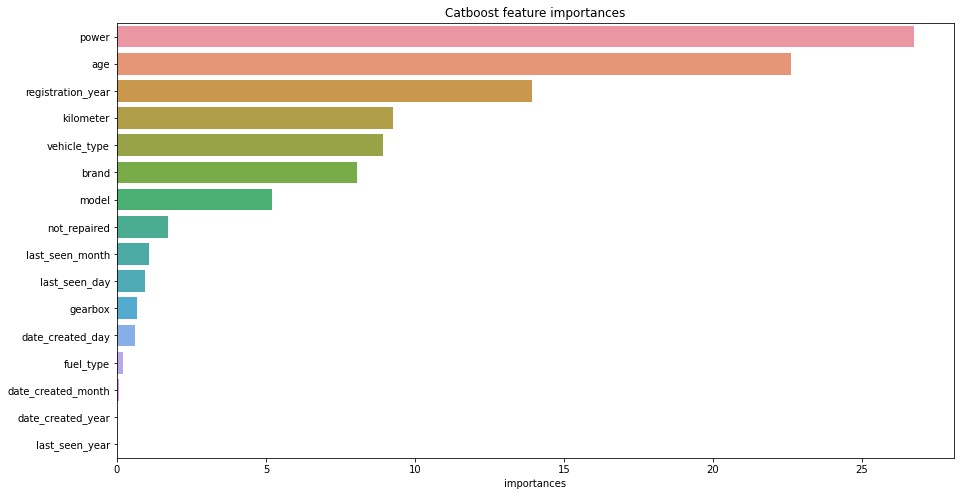

In [19]:
cb_importances = pd.DataFrame(cb_model.feature_importances_, 
                              index=X_train.columns, 
                              columns=['importances'])\
                    .sort_values(by='importances', ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x='importances', y=cb_importances.index, data=cb_importances, )
plt.title('Catboost feature importances');

### LightGBM

In [20]:
%%time
for _ in cat_cols:
    X_train[_] = X_train[_].astype('category')
    X_valid[_] = X_valid[_].astype('category')
    X_test[_] = X_test[_].astype('category')

    
lgb_params = {
#     "early_stopping_rounds":10, 
#     "learning_rate":[0.03, 0.1],
    "max_depth": [4,6,10],
}
lgb_model = lgb.LGBMRegressor(
    random_state=SEED, 
    objective = 'root_mean_squared_error',
    metric ='rmse'
)



lgb_search = RandomizedSearchCV(lgb_model,
                                lgb_params,
                                cv=3,
                                random_state=SEED,
                                n_jobs=-1,
                                verbose=10,
                                scoring='neg_root_mean_squared_error'
                               )
lgb_search.fit(X_train, y_train, categorical_feature=list(cat_cols))
abs(lgb_search.best_score_)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_fe

CPU times: user 6.46 s, sys: 1.53 s, total: 8 s
Wall time: 5.09 s


1544.9453205095913

In [21]:
%%time
lgb_search.predict(X_test)

CPU times: user 339 ms, sys: 14 ms, total: 353 ms
Wall time: 52.7 ms


array([ 867.81270281, 4155.4984857 , 1464.40539833, ..., 9729.65306592,
       3294.03361649,  997.70986981])

In [22]:
report_df = get_scores(report_df, 
                       lgb_search.best_estimator_, 
                       X_test, 
                       y_test, 
                       'lgbm',
                      fit_time=20.3,
                      predict_time=228*MS)
report_df

,RMSE,fit_time,predict_time
random_forest,1814.808110,82.2,6.900000e-03
catboost,1489.032983,812.4,6.216667e-03
lgbm,1530.119366,20.3,1.368000e+07


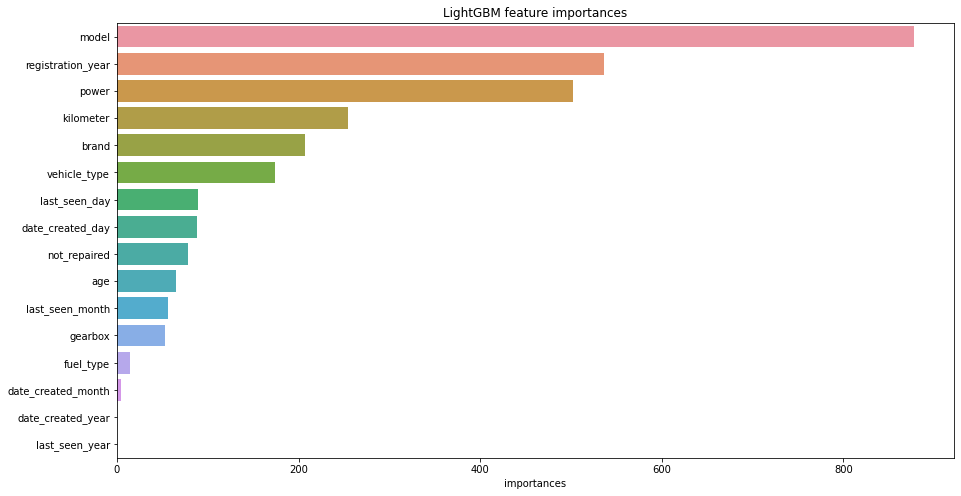

In [23]:
lgb_importances = pd.DataFrame(lgb_search.best_estimator_.feature_importances_,
                               index=X_train.columns,
                               columns=['importances'])\
                    .sort_values(by='importances', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(y=lgb_importances.index, x=lgb_importances.importances, data=lgb_importances);
plt.title('LightGBM feature importances');

## Анализ моделей

In [24]:
%%time
# Проверим модели на тестовой выборке
X_concated = pd.concat([X_train, X_valid])
y_concated = pd.concat([y_train, y_valid])
X_concated['model'] = X_concated['model'].astype('category')

lgb_search.best_estimator_.fit(X_concated,
                              y_concated)


CPU times: user 7.42 s, sys: 1.66 s, total: 9.08 s
Wall time: 2.32 s


LGBMRegressor(max_depth=10, metric='rmse', objective='root_mean_squared_error',
              random_state=41)

In [25]:
%%time
lgb_test_preds = lgb_search.predict(X_test)

CPU times: user 358 ms, sys: 23 ms, total: 381 ms
Wall time: 58 ms


In [26]:
report_df = get_scores(report_df,
                     lgb_search.best_estimator_,
                     X_concated,
                       y_concated,
                       'lgbm_test',
                   fit_time=1.59 * SECONDS,
                       predict_time=246 * MS
                     )
report_df

,RMSE,fit_time,predict_time
random_forest,1814.808110,82.2,6.900000e-03
catboost,1489.032983,812.4,6.216667e-03
lgbm,1530.119366,20.3,1.368000e+07
lgbm_test,1482.415856,95.4,1.476000e+07


In [27]:
report_df

,RMSE,fit_time,predict_time
random_forest,1814.808110,82.2,6.900000e-03
catboost,1489.032983,812.4,6.216667e-03
lgbm,1530.119366,20.3,1.368000e+07
lgbm_test,1482.415856,95.4,1.476000e+07


In [28]:
report_df = report_df.sort_values(by=['RMSE'])

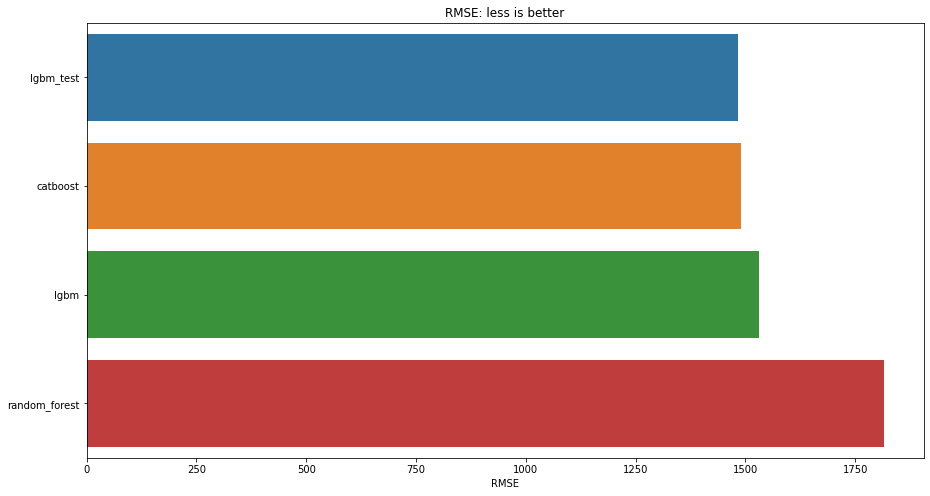

In [29]:
plt.figure(figsize=(15,8))
plt.title('RMSE: less is better')
sns.barplot(x='RMSE', y=report_df.index, data=report_df );


In [30]:
report_df

,RMSE,fit_time,predict_time
lgbm_test,1482.415856,95.4,1.476000e+07
catboost,1489.032983,812.4,6.216667e-03
lgbm,1530.119366,20.3,1.368000e+07
random_forest,1814.808110,82.2,6.900000e-03


In [31]:
report_df.sort_values(by='fit_time')

,RMSE,fit_time,predict_time
lgbm,1530.119366,20.3,1.368000e+07
random_forest,1814.808110,82.2,6.900000e-03
lgbm_test,1482.415856,95.4,1.476000e+07
catboost,1489.032983,812.4,6.216667e-03


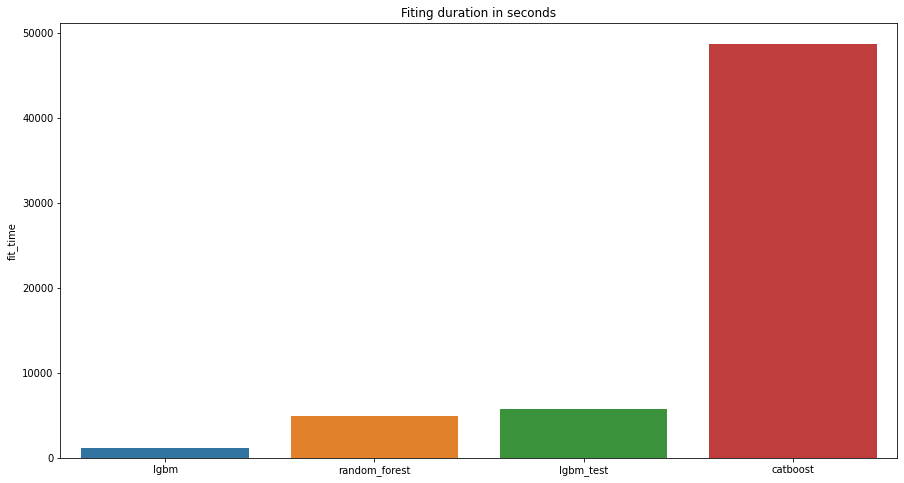

In [32]:
# report_df['fit_duration'] = [15.1, 0.14, 39.35]


report_df = report_df.sort_values(by='fit_time')

plt.figure(figsize=(15,8))
plt.title('Fiting duration in seconds')

sns.barplot(x=report_df.index, y=report_df.fit_time * 60, data=report_df, orient='v');

In [33]:
report_df.sort_values('predict_time')

,RMSE,fit_time,predict_time
catboost,1489.032983,812.4,6.216667e-03
random_forest,1814.808110,82.2,6.900000e-03
lgbm,1530.119366,20.3,1.368000e+07
lgbm_test,1482.415856,95.4,1.476000e+07


In [34]:
report_df['predict_time'] / 60000

lgbm             2.280000e+02
random_forest    1.150000e-07
lgbm_test        2.460000e+02
catboost         1.036111e-07
Name: predict_time, dtype: float64

<AxesSubplot:title={'center':'Predictions time by algoritm in ms'}, ylabel='predict_time'>

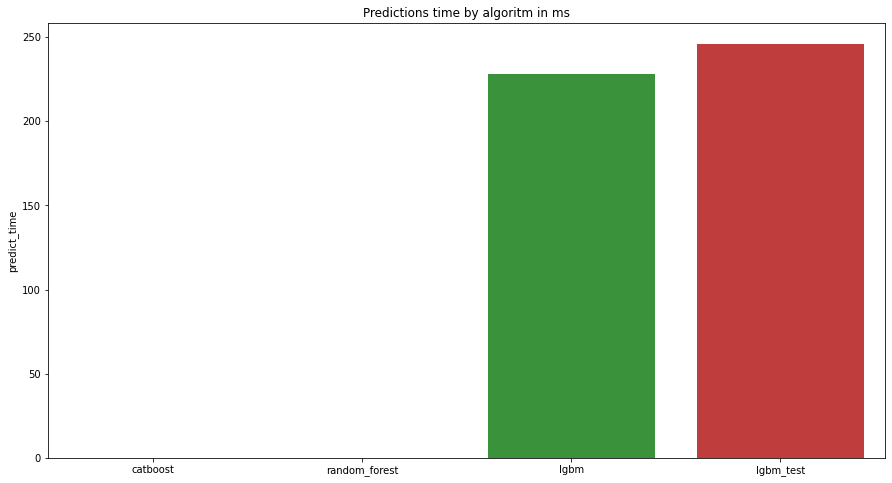

In [35]:
report_df = report_df.sort_values('predict_time')

plt.figure(figsize=(15,8))
plt.title('Predictions time by algoritm in ms')
sns.barplot(x=report_df.index, y=report_df['predict_time'] / MS, data=report_df)

# Вывод

Заказчику важны: 
- качество предсказания;
- скорость предсказания;
- время обучения.



---
- Наилучшей для задач заказчика будет модель Lightgbm. При минимальных временных затратах на обучение и предсказания - эта модель дает отличный результат. 
- Catboost - дает сравнимый результат с точки зрения качества, однако занимает гораздо больше времени в обучении. 
- RandomForest - обучился довольно быстро, благодаря примененному OrdinalEncoder, который не увеличивает датасет, однако качество алгоритма едва ли можно считать удовлетворительным. 
